In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
from catboost import CatBoostClassifier

In [2]:
# Path to the folder containing CSV files
folder_path = 'CIC2017'

# List to hold DataFrames
dfs = []

# Loop through all files in the folder
for file in os.listdir(folder_path):
    print(file)
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        # Read the CSV file into a DataFrame and append it to the list
        df = pd.read_csv(file_path, low_memory=False)
        
        print(df.shape)
        #if file=='Ransomware-All.csv':
        #    continue
        dfs.append(df.iloc[:50000])
        print(len(dfs))

# Concatenate all DataFrames into a single DataFrame
print('concating')
df = pd.concat(dfs, ignore_index=True)


Adware-All.csv
(424147, 85)
1
Benign-All.csv
(1205515, 85)
2
Ransomware-All.csv
(348943, 85)
3
Scareware-All.csv
(400841, 85)
4
SMSmalware-All.csv
(237133, 85)
5
concating


In [3]:
import pandas as pd
from reportlab.lib.pagesizes import letter
from reportlab.platypus import (
    SimpleDocTemplate, Paragraph, Spacer, Table, TableStyle, Image
)
from reportlab.lib import colors
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch
from reportlab.platypus import Paragraph
from reportlab.lib.styles import ParagraphStyle
from reportlab.lib.pagesizes import landscape, letter

def df_to_table(df, available_width):
    # define a style that wraps text
    header_style = ParagraphStyle(
        name='TableHeader',
        fontSize=7,
        leading=8,      # space between wrapped lines
        alignment=1     # center
    )

    # evenly divide page width across columns
    col_widths = [available_width/len(df.columns)] * len(df.columns)

    # build header row with Paragraphs
    data = [[Paragraph(col, header_style) for col in df.columns]]

    # then the data rows as before
    for row in df.itertuples(index=False):
        data.append([str(x) for x in row])

    tbl = Table(data, colWidths=col_widths, repeatRows=1)
    tbl.setStyle(TableStyle([
        ('GRID',        (0,0), (-1,-1), 0.5, colors.grey),
        ('BACKGROUND',  (0,0), (-1,0),   colors.lightgrey),
        ('ALIGN',       (0,1), (-1,-1),'CENTER'),
        ('VALIGN',      (0,0), (-1,-1),'MIDDLE'),
        ('FONTSIZE',    (0,1), (-1,-1), 7),
        ('BOTTOMPADDING',(0,0), (-1,0),  4),
    ]))
    return tbl


def generate_full_report(
        analyses: list,
        output_path: str = "Digital Forensic report.pdf",
        title: str = "Forensics & Detection"):
   
    styles = getSampleStyleSheet()
    doc = SimpleDocTemplate(output_path, pagesize=landscape(letter),
    leftMargin=36, rightMargin=36, topMargin=36, bottomMargin=36
)
    
    elements = []
    
    # Report Title
    elements.append(Paragraph(title, styles['Title']))
    elements.append(Spacer(1, 12))
    available_width = doc.width
    for section_title, content in analyses:
        # Section header
        elements.append(Paragraph(section_title, styles['Heading2']))
        elements.append(Spacer(1, 6))
        
        # Decide what to render
        if 'text' in content:
            elements.append(Paragraph(content['text'], styles['Normal']))
            elements.append(Spacer(1, 12))
        
        if 'df' in content:
            tbl = df_to_table(content['df'],available_width)
            elements.append(tbl)
            elements.append(Spacer(1, 12))
        
        if 'image' in content:
            img = Image(content['image'], 
                        width=content.get('width', 400), 
                        height=content.get('height', 200))
            elements.append(img)
            elements.append(Spacer(1, 12))
    
    # Build the PDF once, at the end
    doc.build(elements)
    print(f"Report written to {output_path}")


In [90]:
analyses = []

In [5]:
set(df[' Label'].values)

{'ADWARE_DOWGIN',
 'ADWARE_EWIND',
 'BENIGN',
 'RANSOMWARE_CHARGER',
 'RANSOMWARE_SIMPLOCKER',
 'RANSOMWARE_SVPENG',
 'RANSOMWARE_WANNALOCKER',
 'SCAREWARE_ANDROIDDEFENDER',
 'SCAREWARE_AVFORANDROID',
 'SCAREWARE_AVPASS',
 'SCAREWARE_FAKETAOBAO',
 'SCAREWARE_VIRUSSHIELD',
 'SMSMALWARE_FAKEMART',
 'SMSMALWARE_NANDROBOX',
 'SMSMALWARE_PLANKTON',
 'SMSMALWARE_SMSSNIFFER',
 nan}

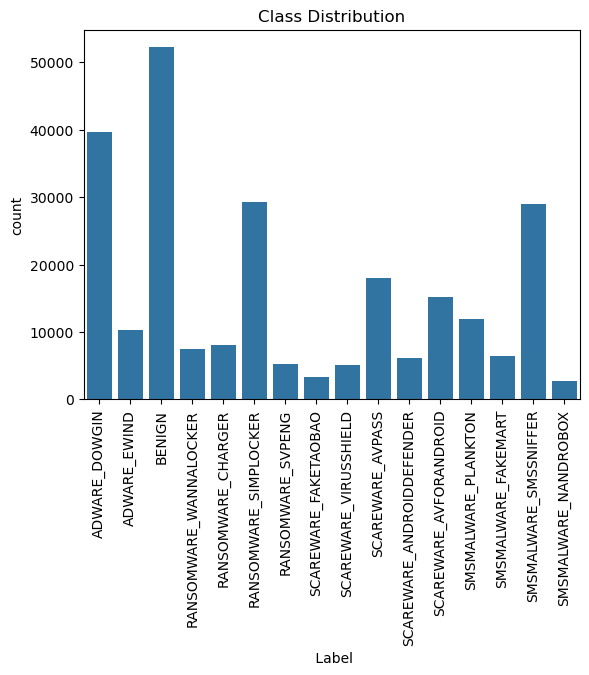

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x=' Label', data=df)  # Replace 'class_column' with the label column
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()


In [7]:
df.shape

(250000, 85)

In [8]:
#we will keep only the general categories here
df['Label'] = df[' Label'].str.split('_').str[0]


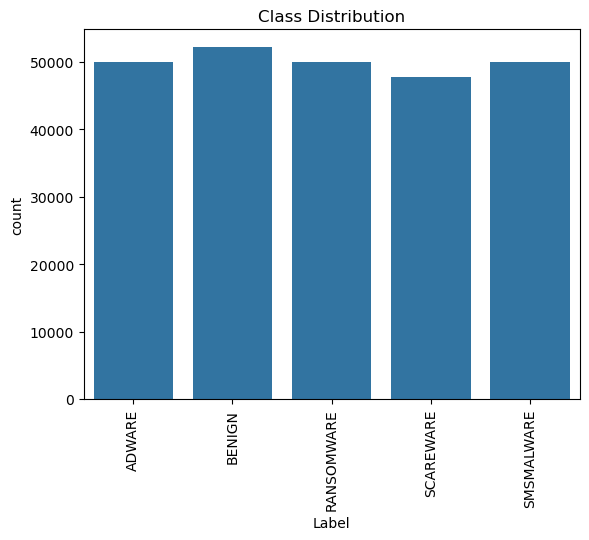

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Label', data=df)  # Replace 'class_column' with the label column
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.savefig("classditribution.png",bbox_inches = 'tight')
plt.show()
analyses.append(("Class Distribution",                     {"image": "classditribution.png", "width": 400, "height": 400}))

In [10]:
df.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
 Idle Std            1
 Idle Max            1
 Idle Min            1
 Label               1
Label                1
Length: 86, dtype: int64

In [11]:
#data preprocessing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()
df = df.drop_duplicates(keep='first')

In [12]:
df.isnull().sum()

Flow ID              0
 Source IP           0
 Source Port         0
 Destination IP      0
 Destination Port    0
                    ..
 Idle Std            0
 Idle Max            0
 Idle Min            0
 Label               0
Label                0
Length: 86, dtype: int64

In [13]:
df.shape

(249999, 86)

In [14]:
np.unique(df['Label'])

array(['ADWARE', 'BENIGN', 'RANSOMWARE', 'SCAREWARE', 'SMSMALWARE'],
      dtype=object)

In [15]:
df.describe()

,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,249999.000000,249999.000000,249999.000000,2.499990e+05,249999.000000,249999.000000,2.499990e+05,2.499990e+05,249999.000000,249999.000000,...,249999.000000,249999.000000,2.499990e+05,2.499990e+05,2.499990e+05,2.499990e+05,2.499990e+05,2.499990e+05,2.499990e+05,2.499990e+05
mean,38986.725111,5585.214329,8.247949,1.133419e+07,7.230261,9.745299,7.059597e+02,1.003252e+04,224.665755,11.898084,...,1.592210,27.193869,1.574871e+05,2.217994e+04,1.792974e+05,1.401039e+05,4.467828e+06,3.413964e+05,4.762727e+06,4.205208e+06
std,18261.627729,14898.281912,4.506788,2.248979e+07,39.784056,115.650601,9.541682e+03,1.651614e+05,437.259985,55.124828,...,8.723402,6.672648,8.513317e+05,2.985896e+05,1.011794e+06,7.990345e+05,1.516056e+07,2.985900e+06,1.589006e+07,1.481055e+07
min,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,-1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,34329.500000,80.000000,6.000000,4.839500e+04,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,43425.000000,443.000000,6.000000,5.309770e+05,2.000000,1.000000,3.100000e+01,3.100000e+01,31.000000,0.000000,...,0.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,52504.000000,443.000000,6.000000,1.093009e+07,5.000000,4.000000,4.440000e+02,4.160000e+02,342.000000,1.000000,...,1.000000,32.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,65532.000000,65428.000000,17.000000,1.199989e+08,8421.000000,19843.000000,4.393732e+06,2.864808e+07,16416.000000,1460.000000,...,3035.000000,172.000000,4.320783e+07,3.147178e+07,6.778153e+07,4.320783e+07,1.198774e+08,7.614790e+07,1.198774e+08,1.198774e+08


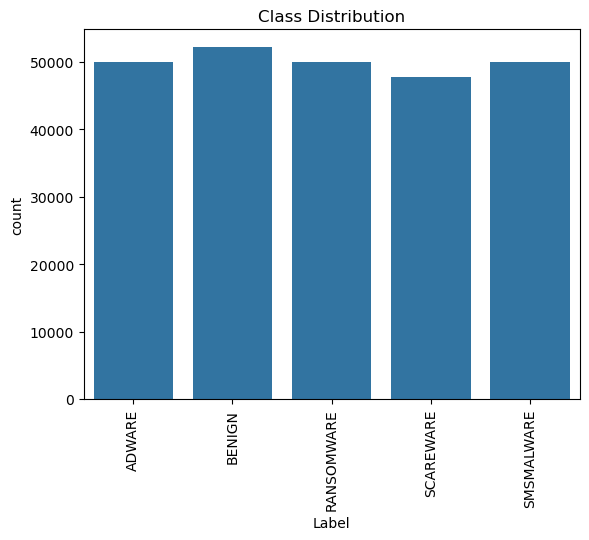

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='Label', data=df)  # Replace 'class_column' with the label column
plt.title('Class Distribution')
plt.xticks(rotation=90)
plt.show()


In [17]:
# Check the distribution of malware labels (if present)
if 'Label' in df.columns:
    print(df['Label'].value_counts())

Label
BENIGN        52232
ADWARE        50000
RANSOMWARE    50000
SMSMALWARE    50000
SCAREWARE     47767
Name: count, dtype: int64


In [18]:
print(df.columns)


Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet Length', ' Max Pa

In [19]:
# Filter the data to focus on apps with potentially harmful permissions
#'MODIFY_PHONE_STATE','SEND_SMS', 'WRITE_EXTERNAL_STORAGE', 'CAMERA', 'RECORD_AUDIO', 'ACCESS_FINE_LOCATION'
#malicious_permissions = [Bwd Packet Length Min ]
malicious_apps = df[df[' Source Port']>60000]['Label']

# Show how many apps have these permissions
#print(f"Number of apps with potentially malicious behavior: {(malicious_apps)}")
# Count class distribution
class_distribution = malicious_apps.value_counts()

# Display the distribution
print(class_distribution)



Label
BENIGN        2293
ADWARE        2263
SMSMALWARE    2116
SCAREWARE     2022
RANSOMWARE    1913
Name: count, dtype: int64


In [20]:
grouped_data = df.groupby(' Source IP').agg({
    'Flow Bytes/s': ['mean', 'std'],
    ' Flow Packets/s': ['mean', 'std'],
    ' Total Fwd Packets': 'sum',
    ' Total Backward Packets': 'sum',
    # Add other features as needed
}).reset_index()

# Rename columns for readability
grouped_data.columns = ['_'.join(col).strip() for col in grouped_data.columns.values]


In [21]:
# Group data by Source IP and aggregate relevant features along with labels
grouped_data = df.groupby(' Source IP').agg({
    'Flow Bytes/s': ['mean', 'std'],
    ' Flow Packets/s': ['mean', 'std'],
    ' Total Fwd Packets': 'sum',
    ' Total Backward Packets': 'sum',
    'Label': ['count', lambda x: (x != 'BENIGN').sum(), lambda x: (x != 'BENIGN').mean()]
}).reset_index()

# Rename columns for better readability
grouped_data.columns = [
    ' Source IP', 
    'Flow Bytes/s Mean', 'Flow Bytes/s Std',
    ' Flow Packets/s Mean', 'Flow Packets/s Std',
    ' Total Fwd Packets', 'Total Backward Packets',
    ' Total Flows', 'Malicious Flows Count', 'Malicious Flows Percentage'
]

# Display the resulting DataFrame
filtered_data = grouped_data[
    (grouped_data['Flow Packets/s Std'].notna()) &  # Check for non-NaN values
    (grouped_data['Flow Packets/s Std'] >= 1000)   # Check for values >= 1000
]

# Display the filtered results
filtered_data.head(n=50)


,Source IP,Flow Bytes/s Mean,Flow Bytes/s Std,Flow Packets/s Mean,Flow Packets/s Std,Total Fwd Packets,Total Backward Packets,Total Flows,Malicious Flows Count,Malicious Flows Percentage
0,0.0.0.0,1.027412e+07,7.253437e+06,32616.254410,23026.783963,134.0,0.0,60,58,0.966667
3,1.31.173.11,0.000000e+00,0.000000e+00,23821.201482,33655.236762,5.0,1.0,2,1,0.500000
7,10.42.0.1,1.610279e+02,3.619337e+02,299.740701,7407.802955,5363.0,0.0,1037,964,0.929605
8,10.42.0.151,9.183822e+04,1.032079e+06,3778.003945,27777.711392,810364.0,1035195.0,90322,63500,0.703040
9,10.42.0.211,4.733208e+04,7.325138e+05,3113.236749,35550.661594,645314.0,935347.0,89360,86065,0.963127
10,10.42.0.42,1.187150e+05,1.377221e+06,4769.806642,35407.352744,284592.0,425834.0,40854,25555,0.625520
18,103.235.46.211,0.000000e+00,0.000000e+00,109301.625927,99444.312169,156.0,0.0,78,69,0.884615
19,103.235.46.212,0.000000e+00,0.000000e+00,89502.576816,103758.696209,132.0,2.0,66,65,0.984848
20,103.235.46.39,0.000000e+00,0.000000e+00,20538.737483,46912.907601,158.0,6.0,80,71,0.887500
21,103.235.47.110,5.097565e+05,1.895454e+05,49331.278304,18343.107811,12.0,0.0,4,4,1.000000


In [22]:
analyses.append(("Malicious percetnage per Source",      { "df": filtered_data.head(n=50)}))

In [23]:
grouped_data.head()

,Source IP,Flow Bytes/s Mean,Flow Bytes/s Std,Flow Packets/s Mean,Flow Packets/s Std,Total Fwd Packets,Total Backward Packets,Total Flows,Malicious Flows Count,Malicious Flows Percentage
0,0.0.0.0,1.027412e+07,7.253437e+06,32616.254410,23026.783963,134.0,0.0,60,58,0.966667
1,1.189.213.161,0.000000e+00,NaN,21505.376344,NaN,2.0,0.0,1,1,1.000000
2,1.189.213.30,0.000000e+00,NaN,10869.565217,NaN,2.0,0.0,1,0,0.000000
3,1.31.173.11,0.000000e+00,0.000000e+00,23821.201482,33655.236762,5.0,1.0,2,1,0.500000
4,1.31.173.33,0.000000e+00,NaN,8097.165992,NaN,2.0,0.0,1,1,1.000000


In [24]:
# Group data by Source IP and aggregate relevant features along with labels
grouped_data_time = df.groupby(' Timestamp').agg({
    'Flow Bytes/s': ['mean', 'std'],
    ' Flow Packets/s': ['mean', 'std'],
    ' Total Fwd Packets': 'sum',
    ' Total Backward Packets': 'sum',
    'Label': ['count', lambda x: (x != 'BENIGN').sum(), lambda x: (x != 'BENIGN').mean()]
}).reset_index()

# Rename columns for better readability
grouped_data_time.columns = [
    ' Timestamp', 
    'Flow Bytes/s Mean', 'Flow Bytes/s Std',
    ' Flow Packets/s Mean', 'Flow Packets/s Std',
    ' Total Fwd Packets', 'Total Backward Packets',
    ' Total Flows', 'Malicious Flows Count', 'Malicious Flows Percentage'
]





In [25]:
grouped_data_time.head()

,Timestamp,Flow Bytes/s Mean,Flow Bytes/s Std,Flow Packets/s Mean,Flow Packets/s Std,Total Fwd Packets,Total Backward Packets,Total Flows,Malicious Flows Count,Malicious Flows Percentage
0,04/07/2017 10:05:16,344.636699,NaN,0.945649,NaN,11.0,7.0,1,1,1.0
1,04/07/2017 10:05:17,738.306183,1044.122617,10251.714290,14363.387887,4.0,0.0,2,2,1.0
2,04/07/2017 10:05:19,158.310273,NaN,0.831462,NaN,14.0,11.0,1,1,1.0
3,04/07/2017 10:05:21,207.046067,NaN,0.562816,NaN,5.0,3.0,1,1,1.0
4,04/07/2017 10:05:23,25.949000,NaN,0.531857,NaN,17.0,21.0,1,1,1.0


In [26]:
analyses.append(("Attack Vs Time",      { "df": grouped_data_time.head(n=50)}))

In [27]:
# Filter rows where 'Malicious Flows Percentage' is 0 and 'Malicious Flows Count' > 10
filtered_data_peak = grouped_data_time[
    (grouped_data_time['Malicious Flows Percentage'] == 1.0) & 
    (grouped_data_time['Malicious Flows Count'] > 10)
]

# Display the filtered DataFrame
filtered_data_peak.head(n=50)


,Timestamp,Flow Bytes/s Mean,Flow Bytes/s Std,Flow Packets/s Mean,Flow Packets/s Std,Total Fwd Packets,Total Backward Packets,Total Flows,Malicious Flows Count,Malicious Flows Percentage
26,04/07/2017 10:06:37,112107.298325,210131.731555,149.373699,218.970855,245.0,392.0,12,12,1.0
104,04/07/2017 10:13:09,151387.752449,241852.719430,236.441069,365.922617,245.0,238.0,16,16,1.0
105,04/07/2017 10:13:10,34649.263881,164956.146544,53.687850,240.345232,360.0,346.0,28,28,1.0
106,04/07/2017 10:13:11,458.296548,519.894154,1.888191,2.545951,67.0,58.0,12,12,1.0
112,04/07/2017 10:13:20,0.000000,0.000000,1.383473,1.775635,18.0,6.0,12,12,1.0
113,04/07/2017 10:13:21,0.000000,0.000000,0.513652,0.819805,28.0,6.0,17,17,1.0
153,04/07/2017 10:15:51,69464.699827,101275.880614,102.330324,112.855359,319.0,379.0,11,11,1.0
157,04/07/2017 10:15:55,3794.567313,9549.002832,17.534195,34.693469,142.0,112.0,14,14,1.0
187,04/07/2017 10:17:51,621465.347026,977328.152433,40109.367486,63043.160768,13.0,18.0,12,12,1.0
328,05/07/2017 08:54:18,26190.063138,103353.188861,97.713125,294.885529,88.0,119.0,17,17,1.0


In [28]:
analyses.append(("Peak Attack Time Analysis",      { "df": filtered_data_peak.head(n=50)}))

In [29]:
# Filter rows where 'Malicious Flows Percentage' is 0
filtered_data_safe = grouped_data_time[
    (grouped_data_time['Malicious Flows Percentage'] ==0 )& 
    (grouped_data_time[' Total Flows'] > 50)
]
# Display the filtered DataFrame
filtered_data_safe.head(n=50)

,Timestamp,Flow Bytes/s Mean,Flow Bytes/s Std,Flow Packets/s Mean,Flow Packets/s Std,Total Fwd Packets,Total Backward Packets,Total Flows,Malicious Flows Count,Malicious Flows Percentage
995,07/07/2017 01:30:22,7815.984659,24799.627420,114.103671,368.895782,170.0,166.0,59,0,0.0
997,07/07/2017 01:30:24,3968.596981,8177.121180,1513.553971,10882.226206,278.0,245.0,54,0,0.0
1623,07/07/2017 01:54:53,30052.772949,129581.638743,222.798810,538.453446,671.0,1304.0,54,0,0.0
1720,07/07/2017 01:57:37,979.008362,7141.524195,24.551098,161.901068,129.0,20.0,65,0,0.0
1765,07/07/2017 01:58:37,2436.613109,14869.717061,44.340082,258.845397,353.0,270.0,53,0,0.0
3345,07/07/2017 04:41:57,376.656680,1993.783644,5.540715,12.848503,123.0,37.0,52,0,0.0
4565,07/07/2017 06:37:34,9972.453734,32803.758962,110.340619,392.853706,361.0,357.0,52,0,0.0
6656,07/07/2017 09:45:53,23896.470301,134611.486704,524.569485,2160.982096,240.0,227.0,53,0,0.0
8896,07/07/2017 12:32:25,649.981491,3820.501971,38.817768,33.184810,130.0,66.0,77,0,0.0
10155,08/07/2017 03:52:19,43848.850433,274676.960252,1479.986738,9994.084639,261.0,305.0,51,0,0.0


In [30]:
analyses.append(("Safe Time Analysis",      { "df": filtered_data_safe.head(n=50)}))

In [31]:
grouped_data_time.columns

Index([' Timestamp', 'Flow Bytes/s Mean', 'Flow Bytes/s Std',
       ' Flow Packets/s Mean', 'Flow Packets/s Std', ' Total Fwd Packets',
       'Total Backward Packets', ' Total Flows', 'Malicious Flows Count',
       'Malicious Flows Percentage'],
      dtype='object')

In [32]:
# Check the distribution of malware labels (if present)
if 'Label' in df.columns:
    print(df['Label'].value_counts())


Label
BENIGN        52232
ADWARE        50000
RANSOMWARE    50000
SMSMALWARE    50000
SCAREWARE     47767
Name: count, dtype: int64


In [33]:
# Split the data into training and testing sets
from sklearn.decomposition import PCA
#top_n_features=top_n_features_df['Feature'].values.tolist()
#top_n_features.append('Label')
#df = df[top_n_features]
X = df.drop(columns=['Label',' Label',' Flow IAT Min',' Packet Length Std',' CWE Flag Count',' Down/Up Ratio','Fwd Avg Bytes/Bulk'])  # Replace with your feature columns
y = df['Label']   # Replace with your target column

#X = X.select_dtypes(include=['number'])
# Apply PCA to DSAE features
#pca = PCA(n_components=20)  # Choose the number of components based on explained variance
#X = pca.fit_transform(X)
X[' Protocol'] = df[' Protocol'].astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.to_csv("Xtrain.csv")
y_train.to_csv("ytrain.csv")
X_test.to_csv("Xtest.csv")
y_test.to_csv("ytest.csv")




In [34]:
threshold = 10  # Customize this based on your data

numerical_features = []
categorical_features = []

# Check the type of the problematic column
for col in X.columns:
    if X[col].dtype=='object':
        categorical_features.append(col)
print(categorical_features)

['Flow ID', ' Source IP', ' Destination IP', ' Protocol', ' Timestamp']


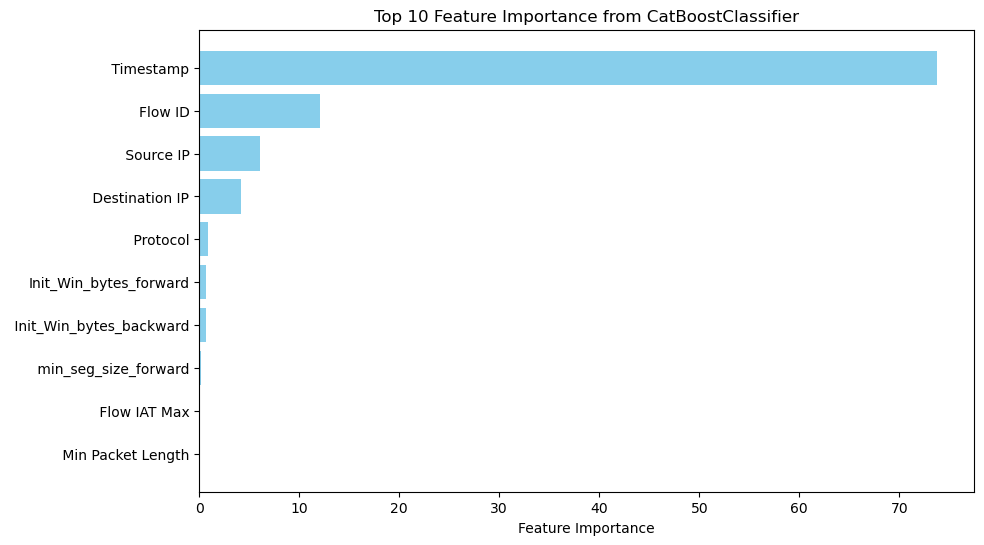

In [35]:

# Initialize and train CatBoostClassifier
model = CatBoostClassifier(iterations=200, depth=6, learning_rate=0.1, random_seed=42)
model.fit(X, y, cat_features=categorical_features, verbose=0)


# Get feature importance
feature_importance = model.get_feature_importance()

# Create a DataFrame to store feature names and their corresponding importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot top 10 most important features
top_10_features = feature_importance_df.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importance from CatBoostClassifier')
plt.gca().invert_yaxis()  # To display the highest importance at the top
plt.savefig("FeatureImportance.png",bbox_inches = 'tight')
plt.show()
analyses.append(("Feature Importance",                     {"image": "FeatureImportance.png", "width": 400, "height": 400}))

In [36]:
top_10_features.head()

,Feature,Importance
6,Timestamp,73.794168
0,Flow ID,12.062251
1,Source IP,6.100794
3,Destination IP,4.193943
5,Protocol,0.913780


In [37]:
top_10 = top_10_features['Feature'].values
X_train=X_train[top_10]
X_test=X_test[top_10]

In [38]:
from catboost import CatBoostClassifier
import time
from datetime import timedelta
time1=time.time()
model = CatBoostClassifier(iterations=100, depth=10, learning_rate=0.1, random_seed=42)
model.fit(X_train, y_train, cat_features=categorical_features, verbose=0)
time2=time.time()

y_pred = model.predict(X_test)
time3=time.time()
train_time = time2-time1 
test_time = time3-time2 
print("train time is " ,str(timedelta(seconds=(train_time))))
print("test time is " ,str(timedelta(seconds=(test_time))))

train time is  0:03:05.023386
test time is  0:00:00.467132


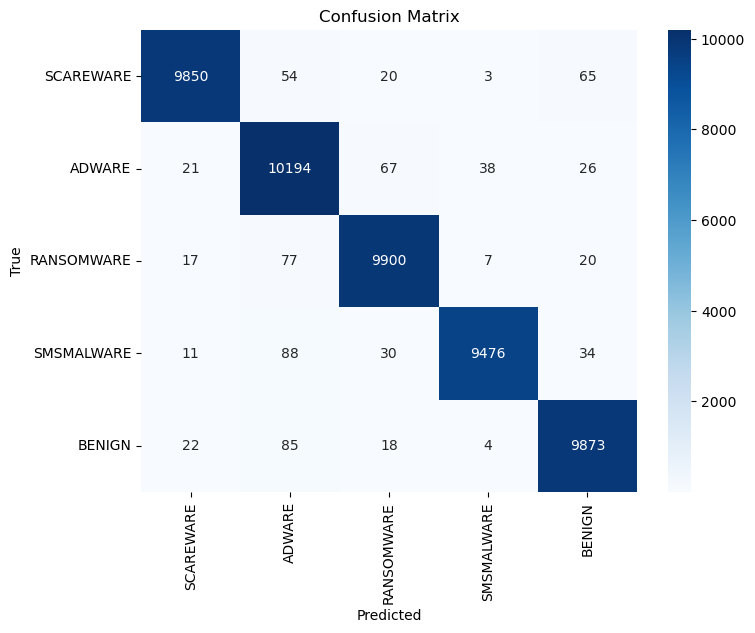

In [39]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes=list(set(y_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("ConfusionMatrix.png",bbox_inches = 'tight')
plt.show()
analyses.append(("Confusion Matrix",                     {"image": "ConfusionMatrix.png", "width": 400, "height": 400}))


In [40]:
from sklearn.metrics import classification_report
# Generate and print the classification report
report = classification_report(y_test, y_pred, output_dict=True, digits=4)
print(report)

report_df   = pd.DataFrame(report).transpose()
report_df.index.name = 'Category'
report_df = report_df.reset_index()
analyses.append(("Classification Report",      { "df": report_df}))


{'ADWARE': {'precision': 0.9928434633605483, 'recall': 0.9857886309047238, 'f1-score': 0.9893034700949128, 'support': 9992.0}, 'BENIGN': {'precision': 0.9710421032577634, 'recall': 0.9853083317224048, 'f1-score': 0.9781232009211284, 'support': 10346.0}, 'RANSOMWARE': {'precision': 0.9865470852017937, 'recall': 0.9879253567508233, 'f1-score': 0.987235739928201, 'support': 10021.0}, 'SCAREWARE': {'precision': 0.9945424013434089, 'recall': 0.98308953210914, 'f1-score': 0.9887828037773256, 'support': 9639.0}, 'SMSMALWARE': {'precision': 0.9855260531044121, 'recall': 0.9871025794841032, 'f1-score': 0.9863136863136863, 'support': 10002.0}, 'accuracy': 0.98586, 'macro avg': {'precision': 0.9861002212535853, 'recall': 0.985842886194239, 'f1-score': 0.9859517802070508, 'support': 50000.0}, 'weighted avg': {'precision': 0.9859341523342008, 'recall': 0.98586, 'f1-score': 0.9858771839171602, 'support': 50000.0}}


In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Calculate Accuracy, Precision, Recall, and F1-Score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred,average='macro')
recall = recall_score(y_test, y_pred,average='macro')
f1 = f1_score(y_test, y_pred,average='macro')

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


Accuracy: 0.9859
Precision: 0.9861
Recall: 0.9858
F1-Score: 0.9860


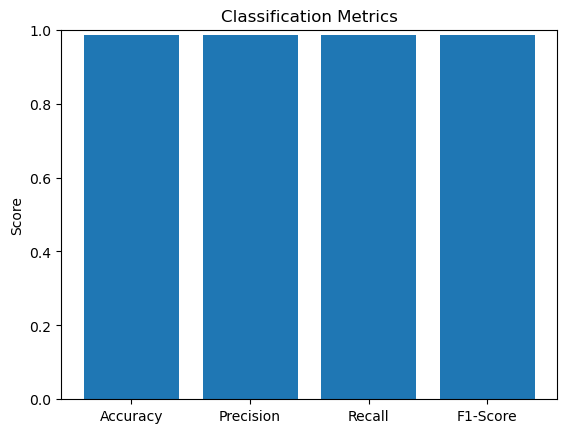

In [42]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores  = [accuracy, precision, recall, f1]

plt.figure()               
plt.bar(metrics, scores)    
plt.ylim(0, 1)              
plt.ylabel('Score')
plt.title('Classification Metrics')
plt.savefig("classificationmetrics.png",bbox_inches = 'tight')
plt.show()
analyses.append(("Classification Metrics",                     {"image": "classificationmetrics.png", "width": 400, "height": 400}))

In [43]:
generate_full_report(analyses)

Report written to Digital Forensic report.pdf
